# 4. Bakery Transaction - Decision Tree

베이커리 판매 데이터의 의사결정나무 중 회귀트리 적합을 통합 판매량 예측<br>
판매 품목에 대한 베이커리 데이터 [Kaggle - Transaction from a bakery](https://www.kaggle.com/sulmansarwar/transactions-from-a-bakery)

<br>

**분석 목표**
- 베이커리 판매에 영향을 주는 요인 찾기
- 베이커리 판매량 예측하기
- 세트 상품으로 출시하면 좋을 조합 제안하기

<br>

---

<br>

[4-1. Decision Tree](#4-1.-Decision-Tree) <br>
　[4-1-1. Decision Tree](#4-1-1.-Decision-Tree)<br>
　[4-1-2. Random Forest](#4-1-2.-Random-Forest)<br>
　[4-1-3. 모델 성능 비교](#4-1-3.-모델-성능-비교)<br>
[4-2. Conclusion of Decision Tree](#4-2.-Conclusion-of-Decision-Tree) <br>

## 4-1. Decision Tree

**필요한 라이브러리 불러오기**

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import graphviz

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error

In [23]:
bakery_data = pd.read_pickle('../input/bakery-data/bakery_data.pkl')
bakery_data = bakery_data.drop(['Date'], axis=1)
bakery_data

,Item,event_day,holiday,Week_Day_Friday,Week_Day_Monday,Week_Day_Saturday,Week_Day_Sunday,Week_Day_Thursday,Week_Day_Tuesday,Week_Day_Wednesday
Date_Time,,,,,,,,,,
2016-10-30,170,0,0,0,0,0,1,0,0,0
2016-10-31,199,0,0,0,1,0,0,0,0,0
2016-11-01,150,0,0,0,0,0,0,0,1,0
2016-11-02,164,0,0,0,0,0,0,0,0,1
2016-11-03,189,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
2017-04-05,143,0,0,0,0,0,0,0,0,1
2017-04-06,118,0,0,0,0,0,0,1,0,0
2017-04-07,99,0,0,1,0,0,0,0,0,0


In [24]:
X = bakery_data[bakery_data.columns.difference(['Item'])]
y = bakery_data['Item']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

129 33
129 33


### 4-1-1. Decision Tree

**모델 튜닝**

의사결정나무의 깊이와 리프노드가 가지고 있어야 할 최소 샘플 수를 Grid Search로 조정한다.

In [25]:
estimator = DecisionTreeRegressor()

grid = GridSearchCV(estimator,
                    param_grid={'max_depth': range(1,10,1),
                                'min_samples_leaf': range(1,10,1)},
                    scoring='neg_mean_squared_error',
                    return_train_score=True,
                    cv=5, iid=True)

grid.fit(X_train,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), iid=True,
             param_grid={'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 10)},
             return_train_score=True, scoring='neg_mean_squared_error')

In [26]:
grid.best_params_

{'max_depth': 4, 'min_samples_leaf': 1}

In [27]:
grid.best_score_

-833.352118972444

**모델 적합**

최대깊이를 조절한 튜닝된 나무와 최대깊이를 설정하지 않은 나무, 최대깊이를 조절된 값보다 적게 한 나무를 생성하여 변수 중요도를 확인해보자.

In [28]:
dt = DecisionTreeRegressor(max_depth=4)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4)

In [29]:
y_pred_dt = dt.predict(X_train)
y_pred_dt

array([106.97183099, 106.97183099, 134.83333333, 106.97183099,
       138.83333333, 183.28571429, 243.4       , 134.83333333,
       138.83333333, 134.83333333, 134.83333333, 183.28571429,
       106.97183099, 106.97183099, 106.97183099, 134.83333333,
       106.97183099, 106.97183099, 106.97183099, 106.97183099,
       106.97183099, 243.4       , 183.28571429, 183.28571429,
       106.97183099, 106.97183099, 183.28571429, 106.97183099,
       106.97183099, 106.97183099, 106.97183099, 106.97183099,
       134.83333333, 106.97183099, 106.97183099, 106.97183099,
       138.83333333, 106.97183099, 138.83333333,   0.        ,
       106.97183099, 106.97183099, 138.83333333, 134.83333333,
       138.83333333, 106.97183099, 106.97183099, 183.28571429,
       106.97183099, 106.97183099, 106.97183099, 106.97183099,
       106.97183099, 106.97183099, 134.83333333, 106.97183099,
       134.83333333, 106.97183099, 134.83333333, 243.4       ,
       138.83333333, 138.83333333, 183.28571429, 183.28

In [30]:
print(len(X_train), len(y_train))

129 129


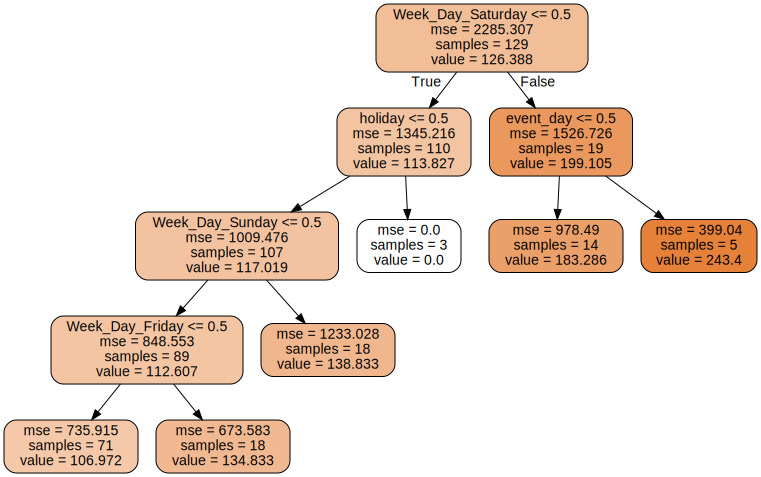

In [31]:
dot_graph = export_graphviz(dt, out_file=None, rounded=True, filled=True, 
                            feature_names = X.columns)

dot = graphviz.Source(dot_graph)
dot

**변수 Feature 중요도 계산**

각 모델 별 노드에서 변수 Feature 중요도를 확인한다.

In [32]:
dt_feature_importances = pd.DataFrame({'feature':X.columns, 'DT':dt.feature_importances_}).sort_values(by='DT', ascending=False)
dt_feature_importances

,feature,DT
2,Week_Day_Saturday,0.611936
8,holiday,0.207538
7,event_day,0.069147
0,Week_Day_Friday,0.057893
3,Week_Day_Sunday,0.053486
1,Week_Day_Monday,0.000000
4,Week_Day_Thursday,0.000000
5,Week_Day_Tuesday,0.000000
6,Week_Day_Wednesday,0.000000


<AxesSubplot:>

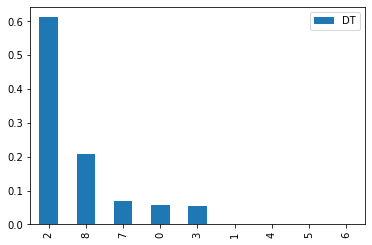

In [33]:
dt_feature_importances.plot.bar()

### 4-1-2. RandomForest

의사결정나무의 성능을 높일 수 있도록 랜덤 포레스트를 생성해보자.

**모델 튜닝**

랜덤포레스트의 파라미터를 Grid Search로 조정한다.

In [34]:
rf_grid = GridSearchCV(estimator=RandomForestRegressor(),
                       param_grid={"n_estimators": [1, 3, 5, 7 ,9, 10, 11, 13, 15, 17, 19, 21],
                                   "min_samples_leaf": [1, 5, 10, 25],
                                   "max_depth": [1, 3, 5, 7, 10, None],
                                   "bootstrap": [True, False]},
                       scoring="neg_mean_squared_error",
                       cv=5)

rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [1, 3, 5, 7, 10, None],
                         'min_samples_leaf': [1, 5, 10, 25],
                         'n_estimators': [1, 3, 5, 7, 9, 10, 11, 13, 15, 17, 19,
                                          21]},
             scoring='neg_mean_squared_error')

In [35]:
rf_grid.best_params_

{'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 19}

In [36]:
rf = RandomForestRegressor(bootstrap=True, max_depth=7, min_samples_leaf=1, n_estimators=7)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, n_estimators=7)

In [37]:
y_pred_rf = rf.predict(X_train)
y_pred_rf

array([109.80634549, 102.87195273, 135.94526227, 104.82879819,
       138.38926299, 182.95791752, 245.77380952, 135.94526227,
       138.38926299, 135.94526227, 135.94526227, 182.95791752,
       115.44902698, 109.80634549, 115.44902698, 135.94526227,
       109.80634549, 104.82879819, 109.80634549, 102.87195273,
       115.44902698, 245.77380952, 182.95791752, 182.95791752,
       115.44902698, 115.44902698, 182.95791752, 109.80634549,
       109.80634549, 109.80634549, 102.87195273, 104.82879819,
       135.94526227, 104.82879819, 109.80634549, 102.87195273,
       138.38926299, 115.44902698, 138.38926299,   0.        ,
       102.87195273, 102.87195273, 138.38926299, 135.94526227,
       138.38926299, 109.80634549, 102.87195273, 182.95791752,
       102.87195273, 109.80634549, 102.87195273, 115.44902698,
       104.82879819, 104.82879819, 135.94526227, 104.82879819,
       135.94526227, 104.82879819, 135.94526227, 245.77380952,
       138.38926299, 138.38926299, 182.95791752, 182.95

### 4-1-3. 모델 성능 비교

의사결정나무와 랜덤포레스트의 RMSE와 scores를  비교해보자.

In [38]:
fit_results = pd.DataFrame(columns=['Model', 'Train_RMSE', 'Test_RMSE', 'Train_Score','Test_Score'], index=range(2))
model_list = [dt, rf]
y_pred_mean_train = [y_train.mean()] * len(y_train)
y_pred_mean_test = [y_test.mean()] * len(y_test)

for idx, model in enumerate(model_list):
    rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
    rmse_test = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    if idx == 1:
        fit_results.loc[idx] = ['RandomForest', rmse_train, rmse_test, score_train, score_test]
    else:
        fit_results.loc[idx] = [model, rmse_train, rmse_test, score_train, score_test]

fit_results.loc[2] = ['Baseline',  np.sqrt(metrics.mean_squared_error(y_train, y_pred_mean_train)), np.sqrt(metrics.mean_squared_error(y_test, y_pred_mean_test)),0.0, 0.0]
fit_results.index = fit_results.Model
fit_results

,Model,Train_RMSE,Test_RMSE,Train_Score,Test_Score
Model,,,,,
DecisionTreeRegressor(max_depth=4),DecisionTreeRegressor(max_depth=4),28.155576,24.028871,0.653116,0.745513
RandomForest,RandomForest,28.00775,24.266234,0.656749,0.740461
Baseline,Baseline,47.804886,47.632219,0.0,0.0


<AxesSubplot:title={'center':'Score for test'}, ylabel='Model'>

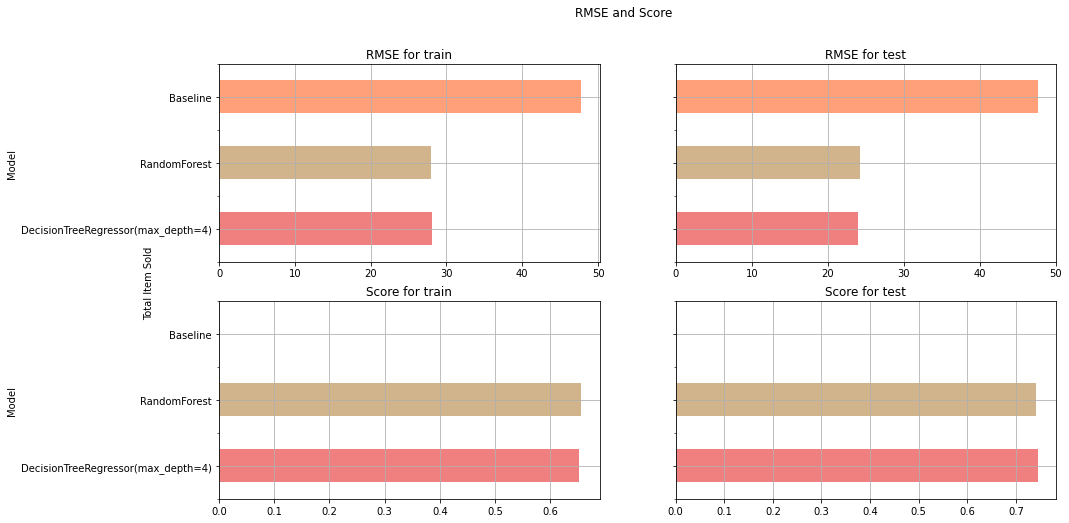

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(15,8), sharex=False, sharey=True, squeeze=False)

fig.suptitle('RMSE and Score', fontsize=12)
fig.text(0.06, 0.5, 'Total Item Sold', ha='center', va='center', rotation='vertical')

RMSE_train_graph = fit_results['Train_RMSE']
RMSE_train_graph.plot(ax=axes[0][0], grid=True, kind='barh', title='RMSE for train', color=['lightcoral', 'tan', 'lightsalmon','rosybrown'])

RMSE_test_graph = fit_results['Test_RMSE']
RMSE_test_graph.plot(ax=axes[0][1], grid=True, kind='barh', title='RMSE for test', color=['lightcoral', 'tan', 'lightsalmon','rosybrown'])

score_train_graph = fit_results['Train_Score']
score_train_graph.plot(ax=axes[1][0], grid=True, kind='barh', title='Score for train', color=['lightcoral', 'tan', 'lightsalmon','rosybrown'])

score_test_graph = fit_results['Test_Score']
score_test_graph.plot(ax=axes[1][1], grid=True, kind='barh', title='Score for test', color=['lightcoral', 'tan', 'lightsalmon','rosybrown'])

In [40]:
results_dt_rf_pred_train = pd.DataFrame({'Actual': y_train, 'DT_Pred': y_pred_dt,'RF_Pred': y_pred_rf})
results_dt_rf_pred_train

,Actual,DT_Pred,RF_Pred
Date_Time,,,
2017-03-30,123,106.971831,109.806345
2016-11-01,150,106.971831,102.871953
2017-03-03,135,134.833333,135.945262
2016-12-14,98,106.971831,104.828798
2016-12-11,92,138.833333,138.389263
...,...,...,...
2017-01-09,82,106.971831,115.449027
2017-02-13,148,106.971831,115.449027
2016-11-13,167,138.833333,138.389263


<AxesSubplot:xlabel='Date_Time'>

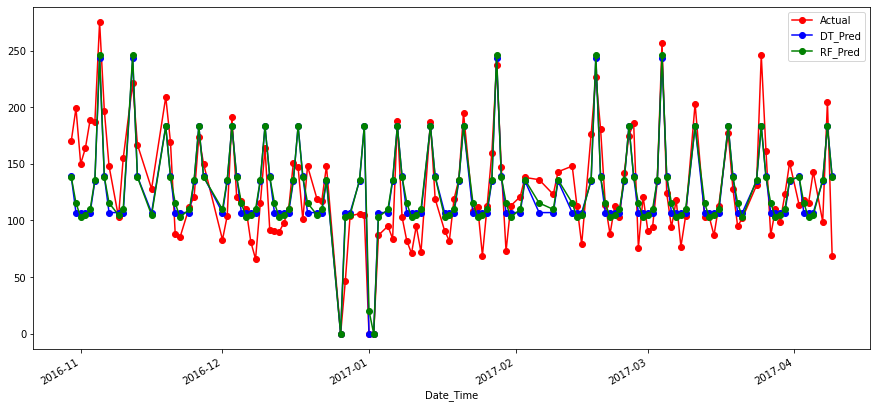

In [41]:
results_dt_rf_pred_train[['Actual', 'DT_Pred', 'RF_Pred']].plot(figsize=(15,7), style={'Actual': '-or', 'DT_Pred': '-ob','RF_Pred': '-og'})

<AxesSubplot:>

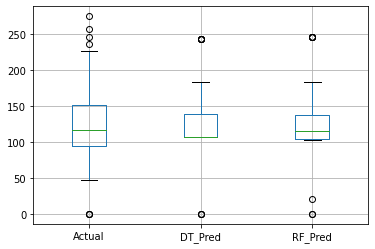

In [42]:
results_dt_rf_pred_train.boxplot()

In [43]:
results_dt_rf_pred_train.describe()

,Actual,DT_Pred,RF_Pred
count,129.000000,129.000000,129.000000
mean,126.387597,126.387597,127.419759
std,47.991261,38.784422,38.354064
min,0.000000,0.000000,0.000000
25%,95.000000,106.971831,104.828798
50%,117.000000,106.971831,115.449027
75%,151.000000,138.833333,138.389263
max,275.000000,243.400000,245.773810


In [44]:
results_dt_rf_pred_test = pd.DataFrame({'Actual': y_test, 'DT_Pred': dt.predict(X_test), 'RF_Pred': rf.predict(X_test)})
results_dt_rf_pred_test

,Actual,DT_Pred,RF_Pred
Date_Time,,,
2017-04-06,118,106.971831,109.806345
2017-02-16,109,106.971831,109.806345
2017-03-10,139,134.833333,135.945262
2016-12-24,169,183.285714,182.957918
2017-02-01,124,106.971831,104.828798
2016-11-28,85,106.971831,115.449027
2017-02-08,103,106.971831,104.828798
2016-12-20,95,106.971831,102.871953
2017-02-07,107,106.971831,102.871953


<AxesSubplot:xlabel='Date_Time'>

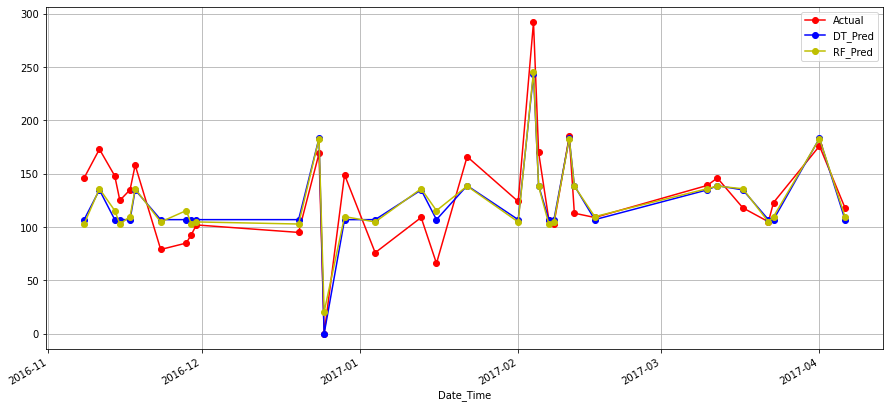

In [45]:
results_dt_rf_pred_test[['Actual', 'DT_Pred', 'RF_Pred']].plot(figsize=(15,7), style={'Actual': '-or', 'DT_Pred': '-ob', 'RF_Pred': '-oy'}, grid=True)

<AxesSubplot:>

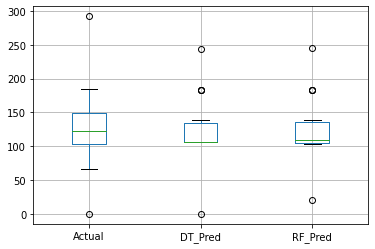

In [46]:
results_dt_rf_pred_test.boxplot()

In [47]:
results_dt_rf_pred_test.describe()

,Actual,DT_Pred,RF_Pred
count,33.000000,33.000000,33.000000
mean,127.333333,122.885513,123.851771
std,48.370747,38.369864,36.734260
min,0.000000,0.000000,20.466165
25%,103.000000,106.971831,104.828798
50%,123.000000,106.971831,109.806345
75%,149.000000,134.833333,135.945262
max,292.000000,243.400000,245.773810


---

## 4-2. Conclusion of Decision Tree

- Decision Tree와 RandomForest의 결과는 큰 차이가 없는 것으로 보인다.
- Week_Day_Saturday와 holiday가 예측에 있어서 가장 중요한 변수라고 볼 수 있다.
- Linear 혹은 Ridge, Lasso Regression과 비슷한 결과를 내고 있지만 RMSE가 꽤 큰 것으로 보아 예측 정확도는 떨어진다.